<img src="https://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>

# Reinforcement Learning for Finance

**Chapter 06 &mdash; Algorithmic Trading**

&copy; Dr. Yves J. Hilpisch

<a href="https://tpq.io" target="_blank">https://tpq.io</a> | <a href="https://twitter.com/dyjh" target="_blank">@dyjh</a> | <a href="mailto:team@tpq.io">team@tpq.io</a>

## Prediction Game Revisited

In [1]:
import math
import random
import numpy as np
import pandas as pd
from pylab import plt, mpl

In [2]:
plt.style.use('seaborn-v0_8')
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'
np.set_printoptions(suppress=True)

In [3]:
from finance import *

In [4]:
finance = Finance('GLD', 'r', min_accuracy=47.5,
              n_features=8)

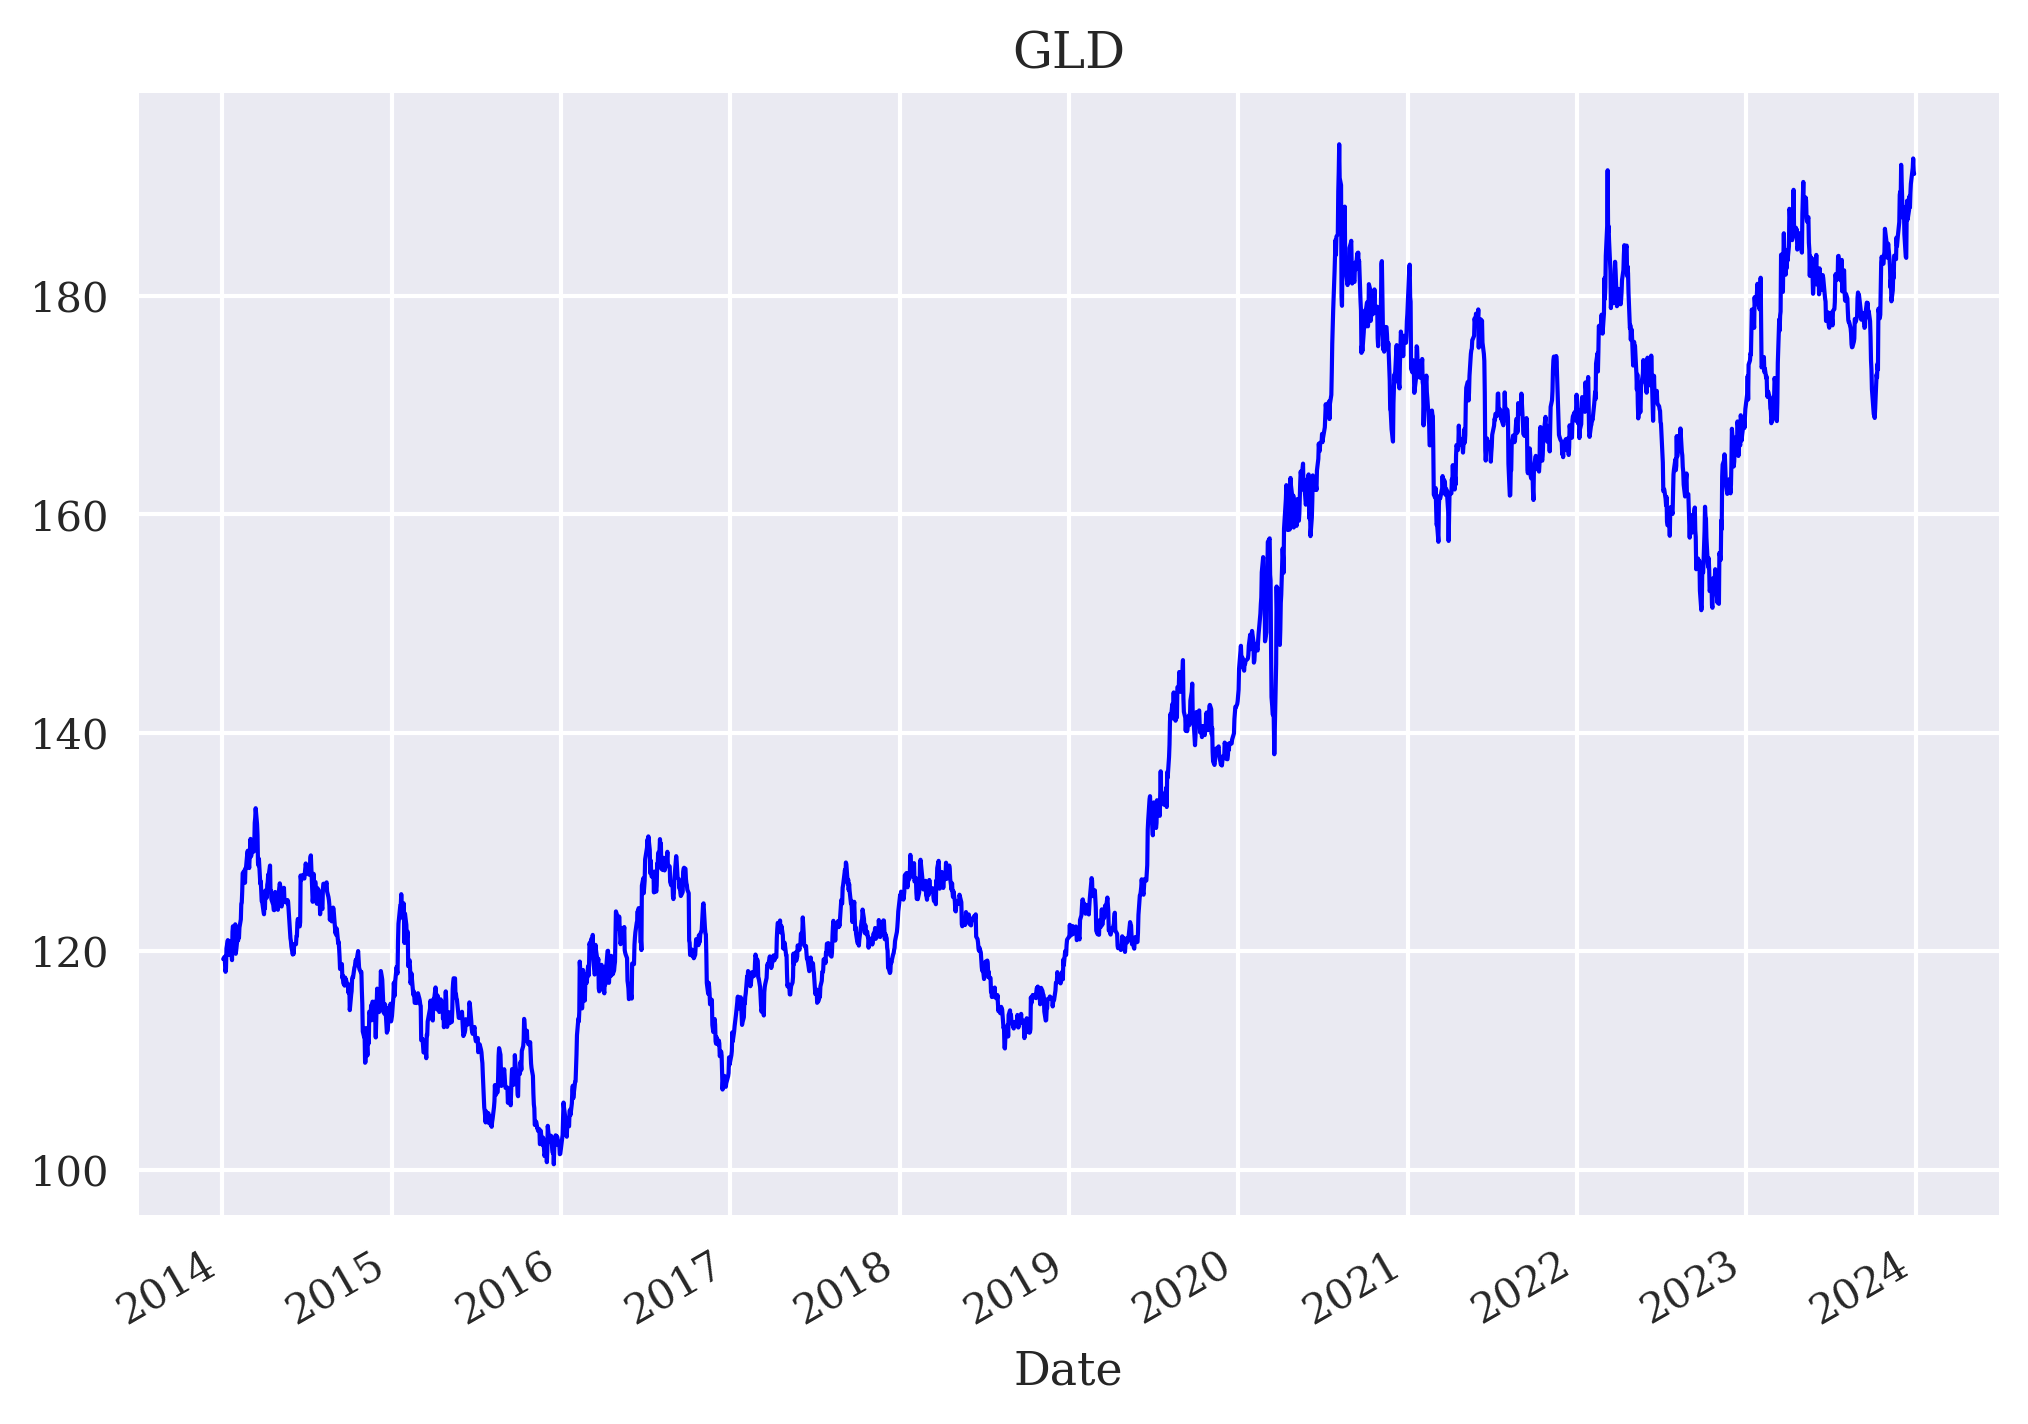

In [5]:
finance.data[finance.symbol].plot(title=finance.symbol,
                                  lw=1.0, c='b');

In [6]:
from dqlagent import *

In [7]:
random.seed(100)
tf.random.set_seed(100)

In [8]:
dqlagent = DQLAgent(finance.symbol, finance.feature,
                 finance.n_features, finance, lr=0.0001)

In [9]:
%time dqlagent.learn(500)

episode= 500 | treward=  7.000 | max= 13.000
CPU times: user 22.3 s, sys: 3.95 s, total: 26.2 s
Wall time: 21.8 s


In [10]:
dqlagent.test(3)

total reward=2507 | accuracy=0.516
total reward=2507 | accuracy=0.516
total reward=2507 | accuracy=0.516



In [11]:
from simulation import Simulation

In [12]:
random.seed(500)

In [13]:
simulation = Simulation('SYMBOL', 'r', 4, '2025-1-1', '2027-1-1',
                2 * 252, min_accuracy=0.5, x0=1, kappa=1,
                theta=0.75, sigma=0.1, new=True, normalize=True)

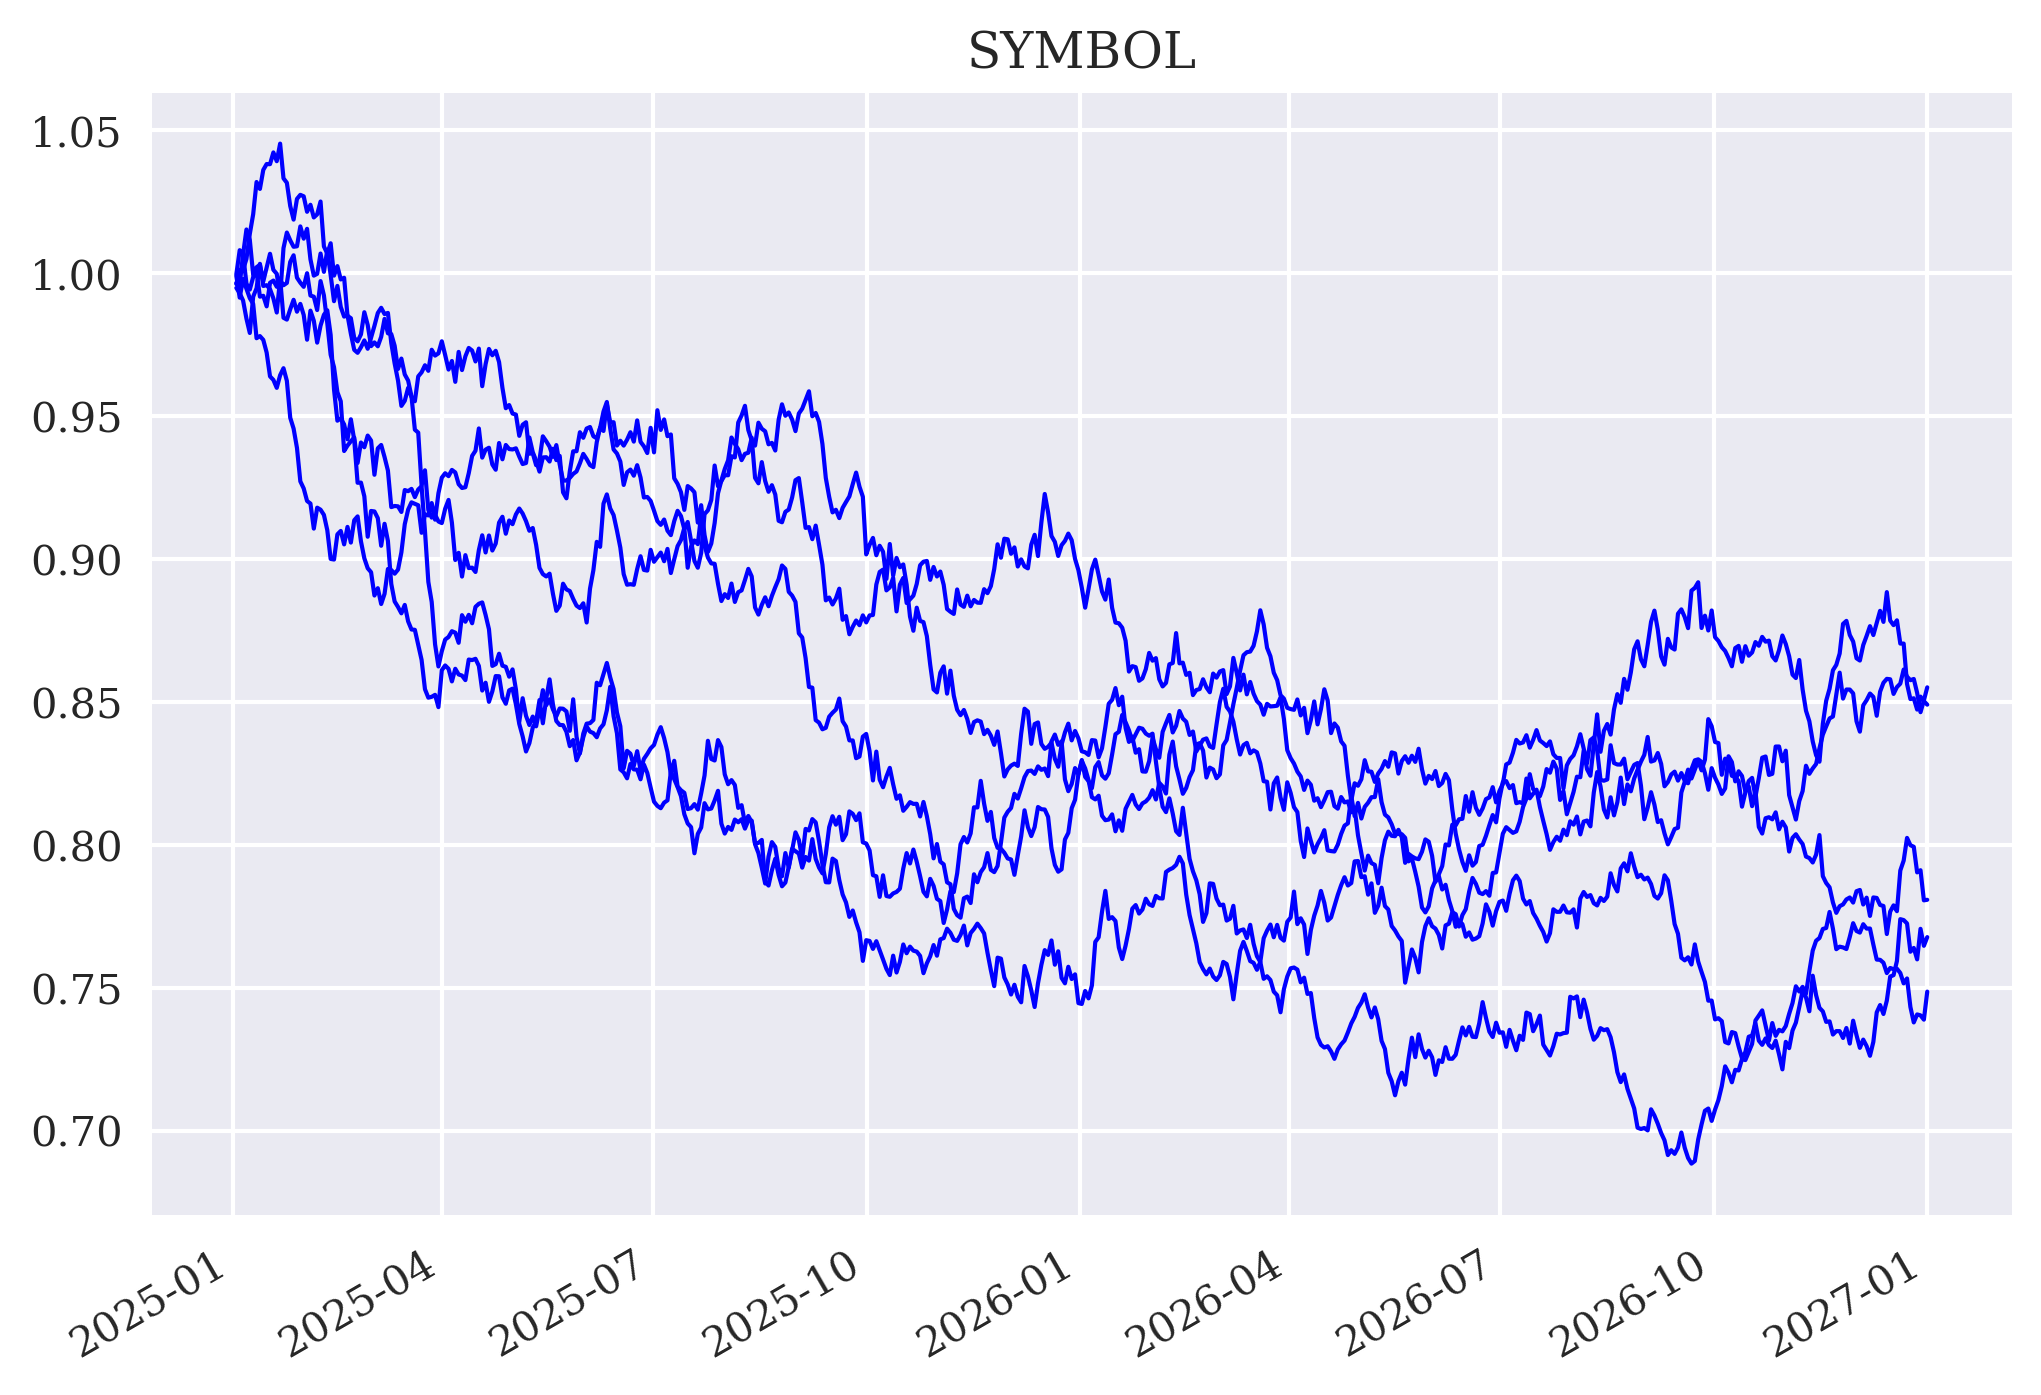

In [14]:
for _ in range(5):
    simulation.reset()
    simulation.data[simulation.symbol].plot(title=simulation.symbol,
                                           lw=1.0, c='b');

In [15]:
random.seed(100)
tf.random.set_seed(100)

In [16]:
agent = DQLAgent(simulation.symbol, simulation.feature,
                 simulation.n_features, simulation)

In [17]:
%time agent.learn(250)

episode= 250 | treward=  6.000 | max=278.000
CPU times: user 14.8 s, sys: 2.61 s, total: 17.5 s
Wall time: 14.5 s


In [18]:
agent.test(5)

total reward= 499 | accuracy=0.519
total reward= 499 | accuracy=0.539
total reward= 499 | accuracy=0.521
total reward= 499 | accuracy=0.529
total reward= 499 | accuracy=0.535



In [19]:
class ActionSpace:
    def sample(self):
        return random.randint(0, 1)

In [20]:
class Trading:
    def __init__(self, symbol, features, window, lags,
                 start, end, periods,
                 x0=100, kappa=1, theta=100, sigma=0.2,
                 leverage=1, min_accuracy=0.5, min_performance=0.85,
                 mu=None, std=None,
                 new=True, normalize=True):
        self.symbol = symbol
        self.features = features
        self.n_features = len(features)
        self.window = window
        self.lags = lags
        self.start = start
        self.end = end
        self.periods = periods
        self.x0 = x0
        self.kappa = kappa
        self.theta = theta
        self.sigma = sigma
        self.leverage = leverage
        self.min_accuracy = min_accuracy
        self.min_performance = min_performance
        self.start = start
        self.end = end
        self.mu = mu
        self.std = std
        self.new = new
        self.normalize = normalize
        self.action_space = ActionSpace()
        self._simulate_data()
        self._prepare_data()

In [21]:
class Trading(Trading):
    def _simulate_data(self):
        index = pd.date_range(start=self.start,
                    end=self.end, periods=self.periods)
        s = [self.x0]
        dt = (index[-1] - index[0]).days / 365 / self.periods
        for t in range(1, len(index)):
            s_ = (s[t - 1] + self.kappa * (self.theta - s[t - 1]) * dt +
              s[t - 1] * self.sigma * math.sqrt(dt) *
                random.gauss(0, 1))
            s.append(s_)
        self.data = pd.DataFrame(s, columns=[self.symbol], index=index)

In [22]:
class Trading(Trading):
    def _prepare_data(self):
        self.data['r'] = np.log(self.data / self.data.shift(1))
        self.data.dropna(inplace=True)
        # additional features
        if self.window > 0:
            self.data['SMA'] = self.data[
                self.symbol].rolling(self.window).mean()
            self.data['DEL'] = self.data[
                self.symbol] - self.data['SMA']
            self.data['MIN'] = self.data[
                self.symbol].rolling(self.window).min()
            self.data['MAX'] = self.data[
                self.symbol].rolling(self.window).max()
            self.data['MOM'] = self.data['r'].rolling(
                self.window).mean()
            # add more features here
            self.data.dropna(inplace=True)
        if self.normalize:
            if self.mu is None or self.std is None:
                self.mu = self.data.mean()
                self.std = self.data.std()
            self.data_ = (self.data - self.mu) / self.std
        else:
            self.data_ = self.data.copy()
        self.data['d'] = np.where(self.data['r'] > 0, 1, 0)
        self.data['d'] = self.data['d'].astype(int)

In [23]:
class Trading(Trading):
    def _get_state(self):
        return self.data_[self.features].iloc[self.bar -
                                self.lags:self.bar]
    def seed(self, seed):
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_random_seed(seed)
    def reset(self):
        if self.new:
            self._simulate_data()
            self._prepare_data()
        self.treward = 0
        self.accuracy = 0
        self.actions = list()
        self.returns = list()
        self.performance = 1
        self.bar = self.lags
        state = self._get_state()
        return state.values, {}

In [24]:
class Trading(Trading):
    def step(self, action):
        correct = action == self.data['d'].iloc[self.bar]
        ret = self.data['r'].iloc[self.bar] * self.leverage
        reward_ = 1 if correct else 0
        pl = abs(ret) if correct else -abs(ret)
        reward = reward_
        # alternative options:
        # reward = pl  # only the P&L in log returns
        # reward = reward_ + 10 * pl  # the reward + the scaled P&L
        self.treward += reward
        self.bar += 1
        self.accuracy = self.treward / (self.bar - self.lags) 
        self.performance *= math.exp(pl)
        if self.bar >= len(self.data):
            done = True
        elif reward_ == 1:
            done = False
        elif (self.accuracy < self.min_accuracy and
              self.bar > self.lags + 15):
            done = True
        elif (self.performance < self.min_performance and
              self.bar > self.lags + 15):
            done = True
        else:
            done = False
        state = self._get_state()
        return state.values, reward, done, False, {}

In [25]:
symbol = 'SYMBOL'

In [26]:
trading = Trading(symbol, [symbol, 'r', 'DEL'], window=10, lags=5,
            start='2024-1-1', end='2026-1-1', periods=504,
            x0=100, kappa=2, theta=300, sigma=0.1, normalize=False)

In [27]:
random.seed(750)

In [28]:
trading.reset()

(array([[115.90591443,   0.01926915,   6.89239862],
        [117.17850569,   0.01091968,   6.5901155 ],
        [118.79489427,   0.01369997,   6.65876779],
        [120.63380354,   0.01536111,   6.92684742],
        [121.81132396,   0.00971378,   6.65768164]]),
 {})

In [29]:
trading.data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 494 entries, 2024-01-15 12:47:14.194831014 to 2026-01-01 00:00:00
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SYMBOL  494 non-null    float64
 1   r       494 non-null    float64
 2   SMA     494 non-null    float64
 3   DEL     494 non-null    float64
 4   MIN     494 non-null    float64
 5   MAX     494 non-null    float64
 6   MOM     494 non-null    float64
 7   d       494 non-null    int64  
dtypes: float64(7), int64(1)
memory usage: 34.7 KB


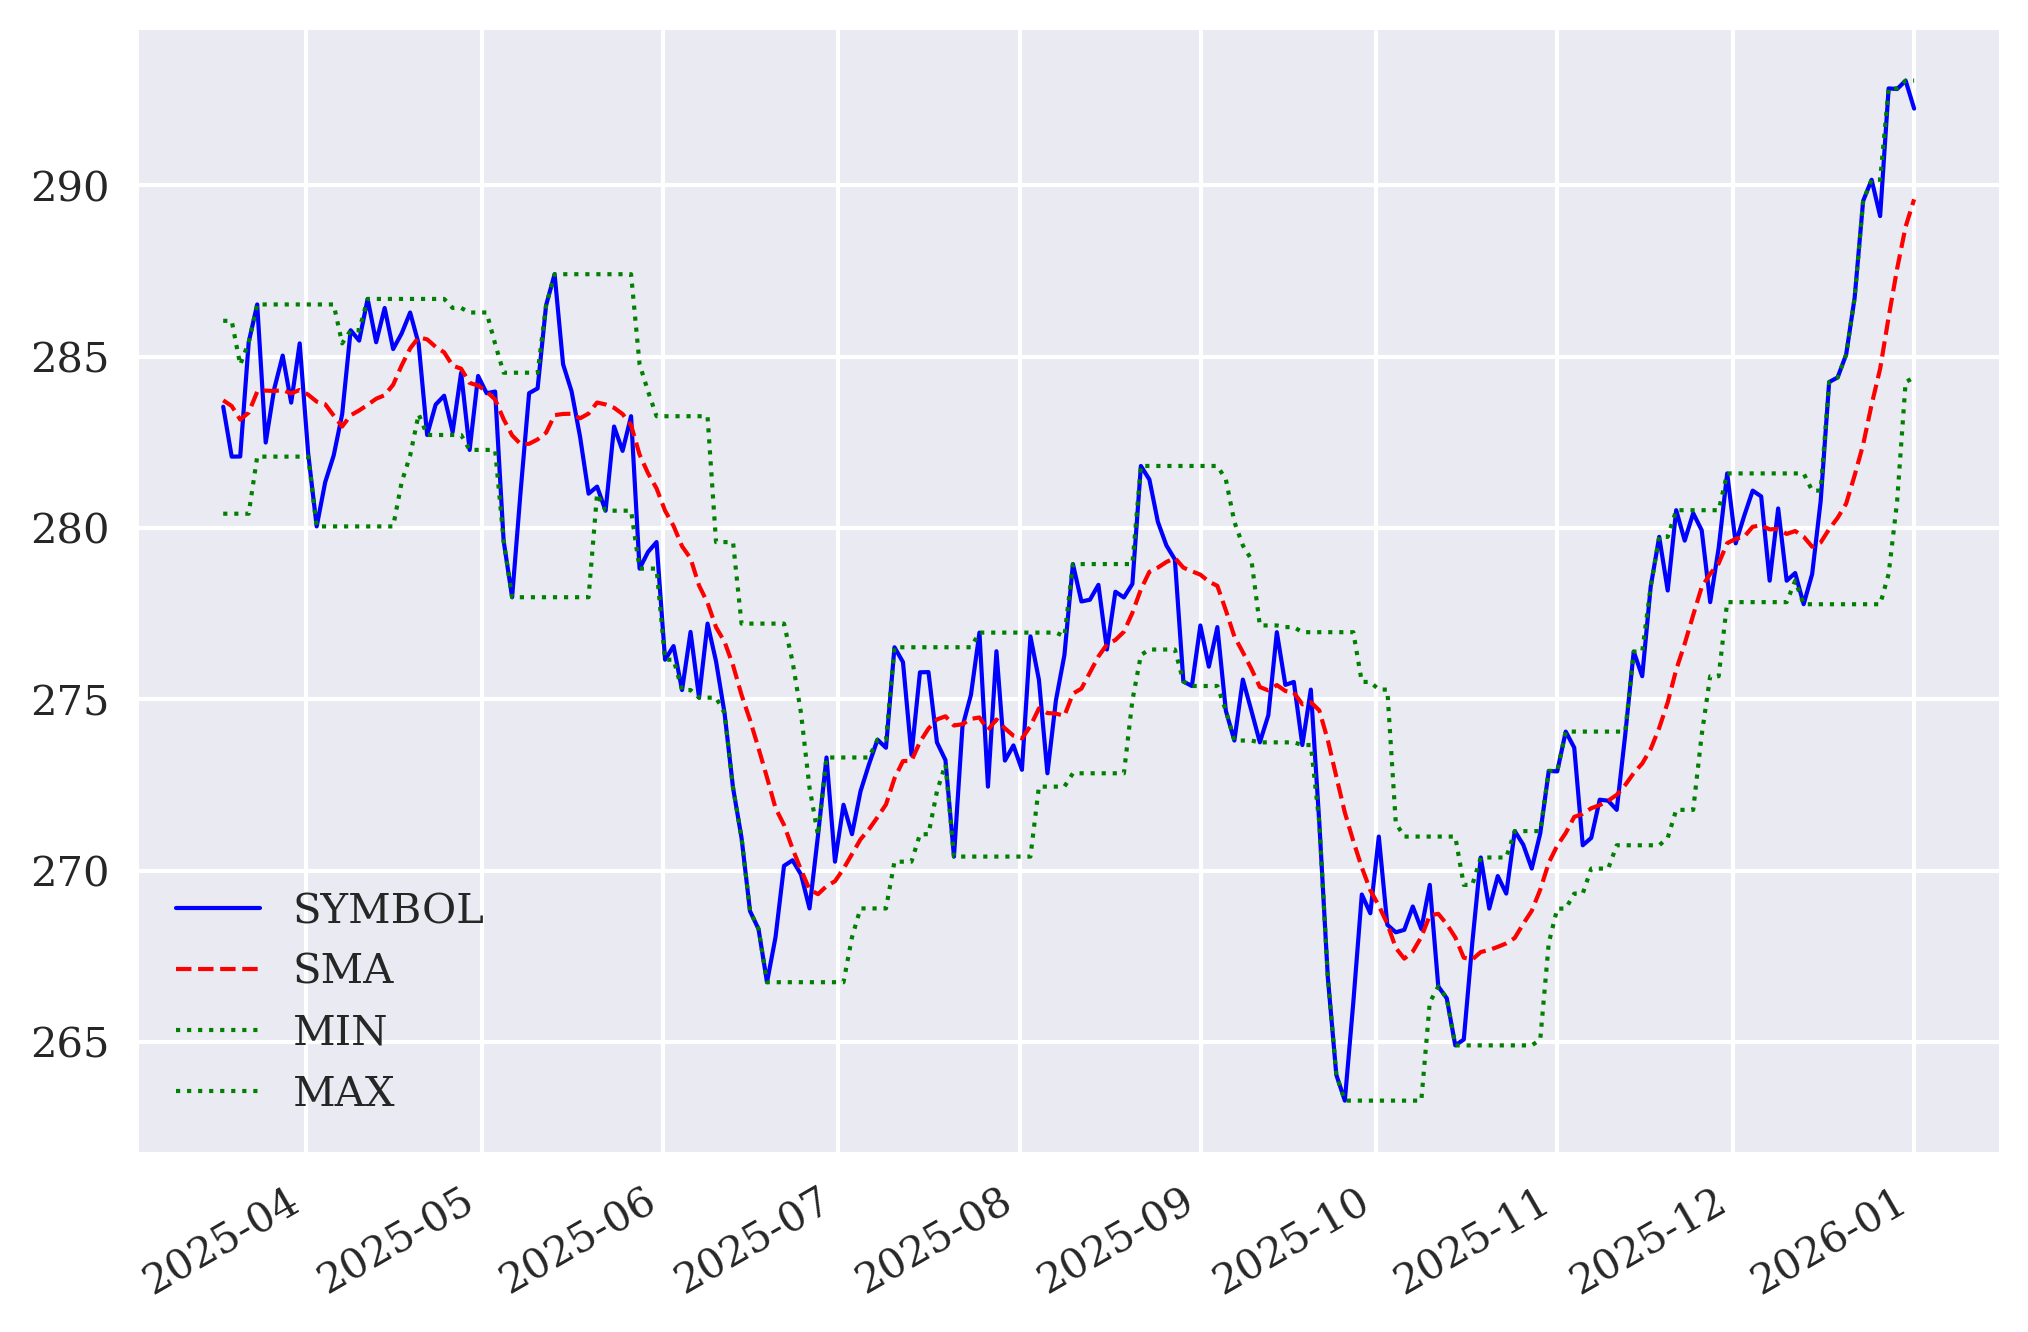

In [30]:
trading.data.iloc[-200:][
    [trading.symbol, 'SMA', 'MIN', 'MAX']].plot(
        style=['b-', 'r--', 'g:', 'g:'], lw=1.0);

In [31]:
class TradingAgent(DQLAgent):
    def _create_model(self, hu, lr):
        self.model = Sequential()
        self.model.add(Dense(hu, input_dim=
            self.env.lags * self.env.n_features,
                        activation='relu'))
        self.model.add(Flatten())
        self.model.add(Dense(hu, activation='relu'))
        self.model.add(Dense(2, activation='linear'))
        self.model.compile(loss='mse',
            optimizer=opt(learning_rate=lr))

In [32]:
random.seed(100)
tf.random.set_seed(100)

In [33]:
trading = Trading(symbol, ['r', 'DEL', 'MOM'], window=10, lags=8,
            start='2024-1-1', end='2026-1-1', periods=2 * 252,
            x0=100, kappa=2, theta=50, sigma=0.1,
            leverage=1, min_accuracy=0.5, min_performance=0.85,
            new=True, normalize=True)

In [34]:
tradingagent = TradingAgent(trading.symbol, trading.features,
                 trading.n_features, trading, hu=24, lr=0.0001)

In [35]:
%%time
tradingagent.test(100, min_accuracy=0.0,
           min_performance=0.0,
           verbose=True, full=False)

total reward= 486 | accuracy=0.447 | performance=0.662
CPU times: user 29.8 s, sys: 3.61 s, total: 33.4 s
Wall time: 29.8 s


In [36]:
random_performances = tradingagent.performances

In [37]:
sum(random_performances) / len(random_performances)

0.7349392873819823

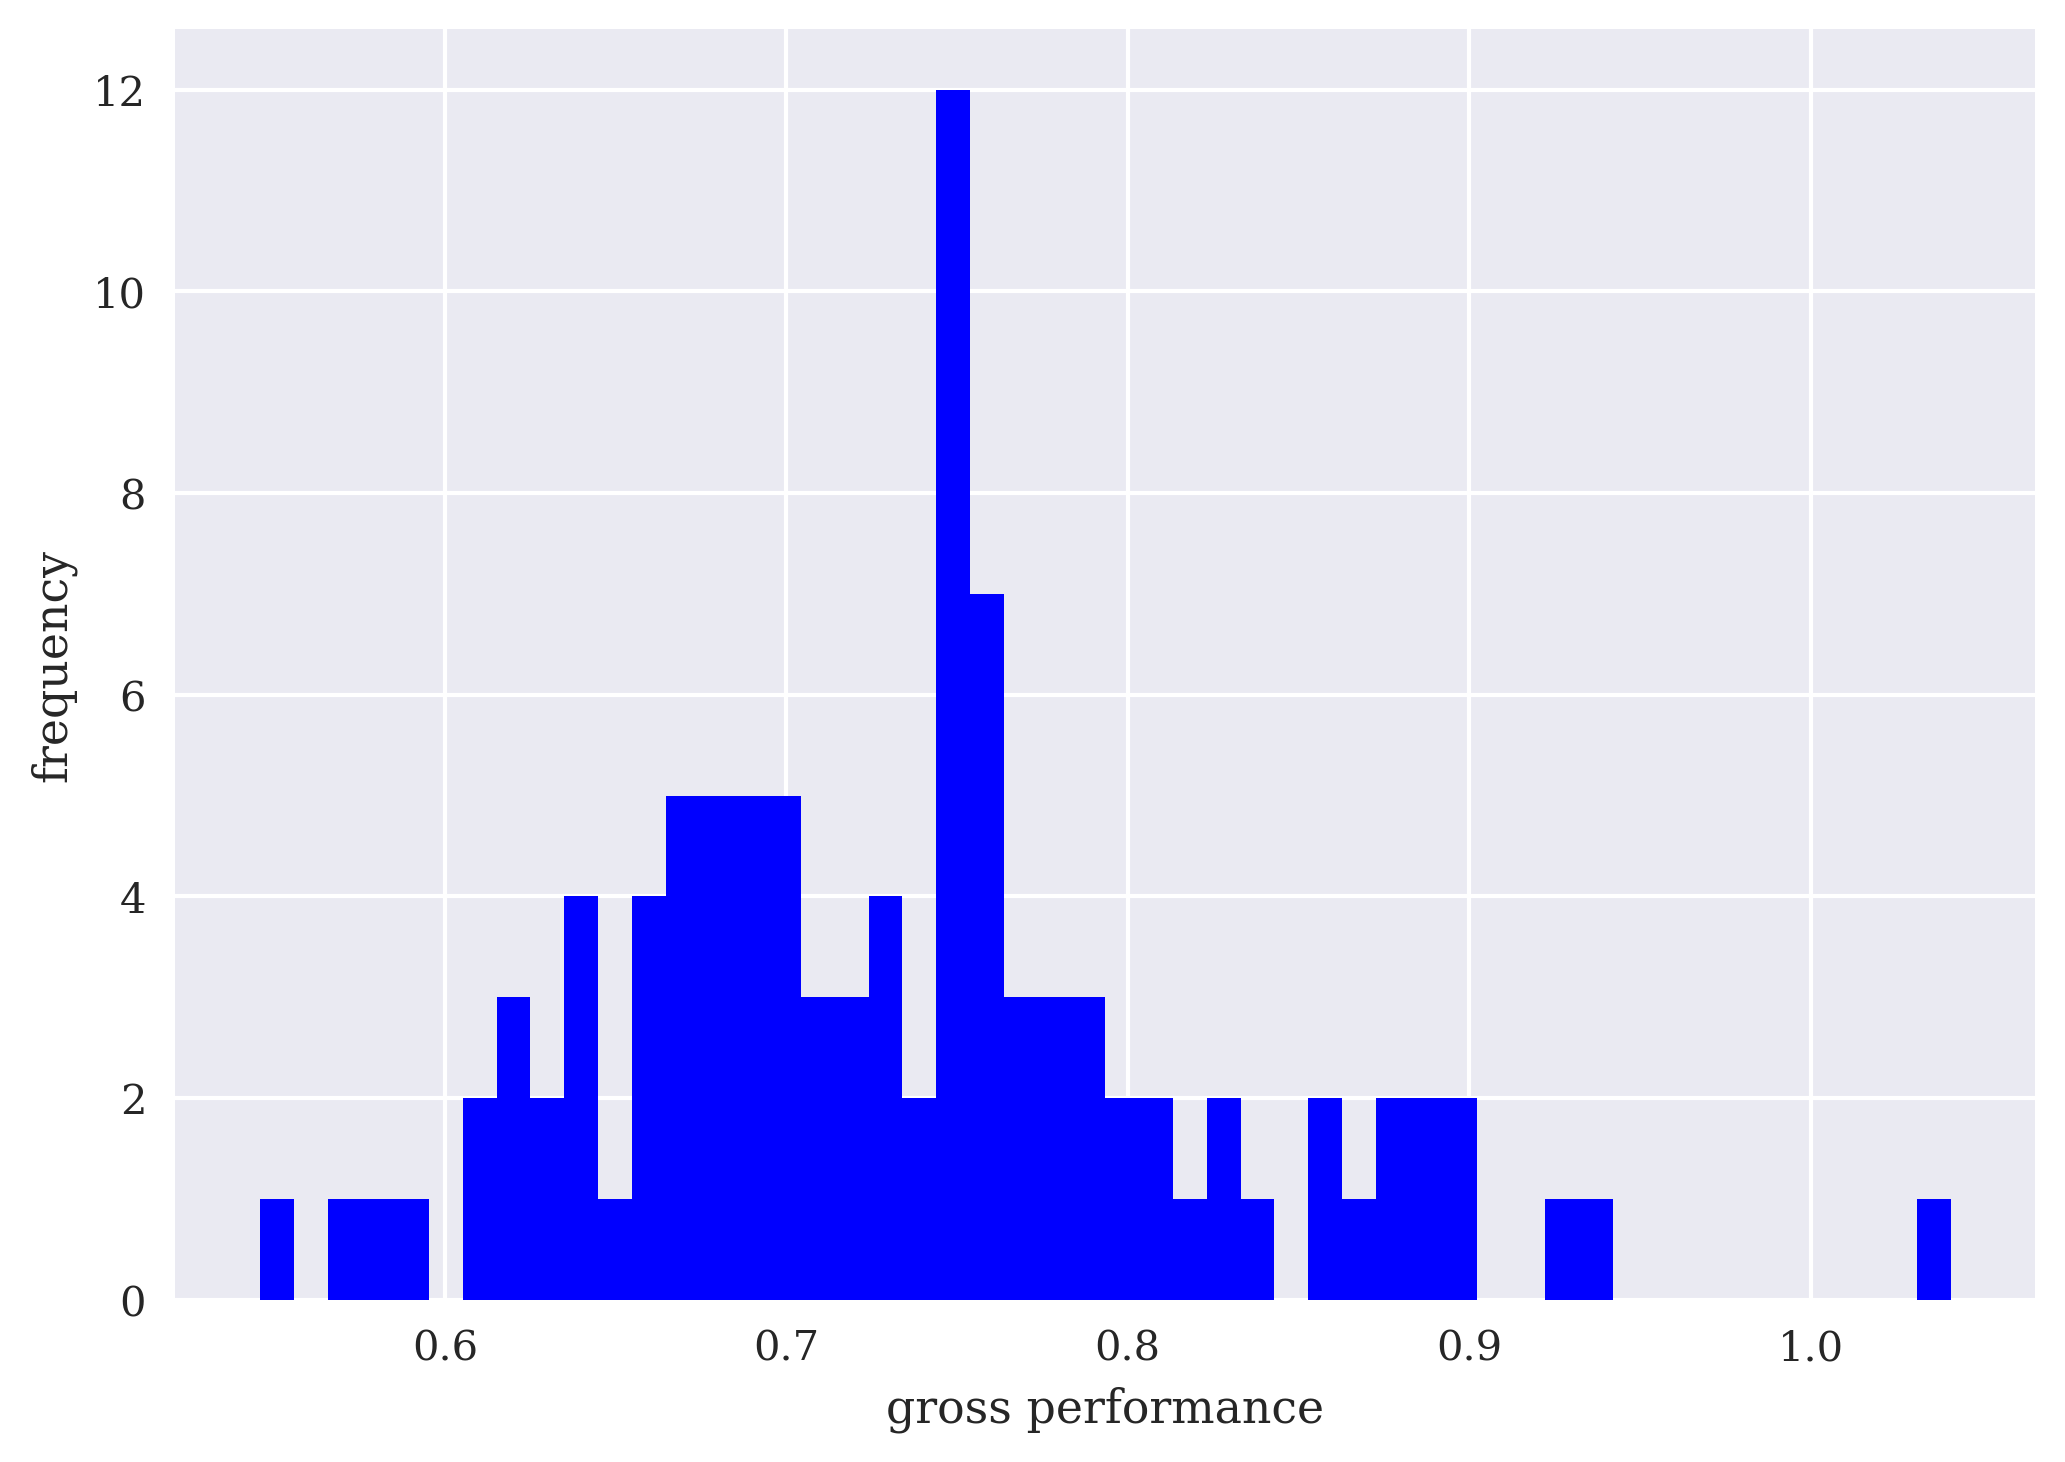

In [38]:
plt.hist(random_performances, bins=50, color='b')
plt.xlabel('gross performance')
plt.ylabel('frequency');

In [39]:
%time tradingagent.learn(500)

episode= 500 | treward=  9.000 | max=284.000
CPU times: user 1min 15s, sys: 10.2 s, total: 1min 25s
Wall time: 1min 14s


In [40]:
%%time
tradingagent.test(50, min_accuracy=0.0,
           min_performance=0.0,
           verbose=True, full=False)

total reward= 486 | accuracy=0.551 | performance=1.575
CPU times: user 14.8 s, sys: 1.82 s, total: 16.7 s
Wall time: 14.8 s


In [41]:
sum(tradingagent.performances) / len(tradingagent.performances)

1.6393329005543225

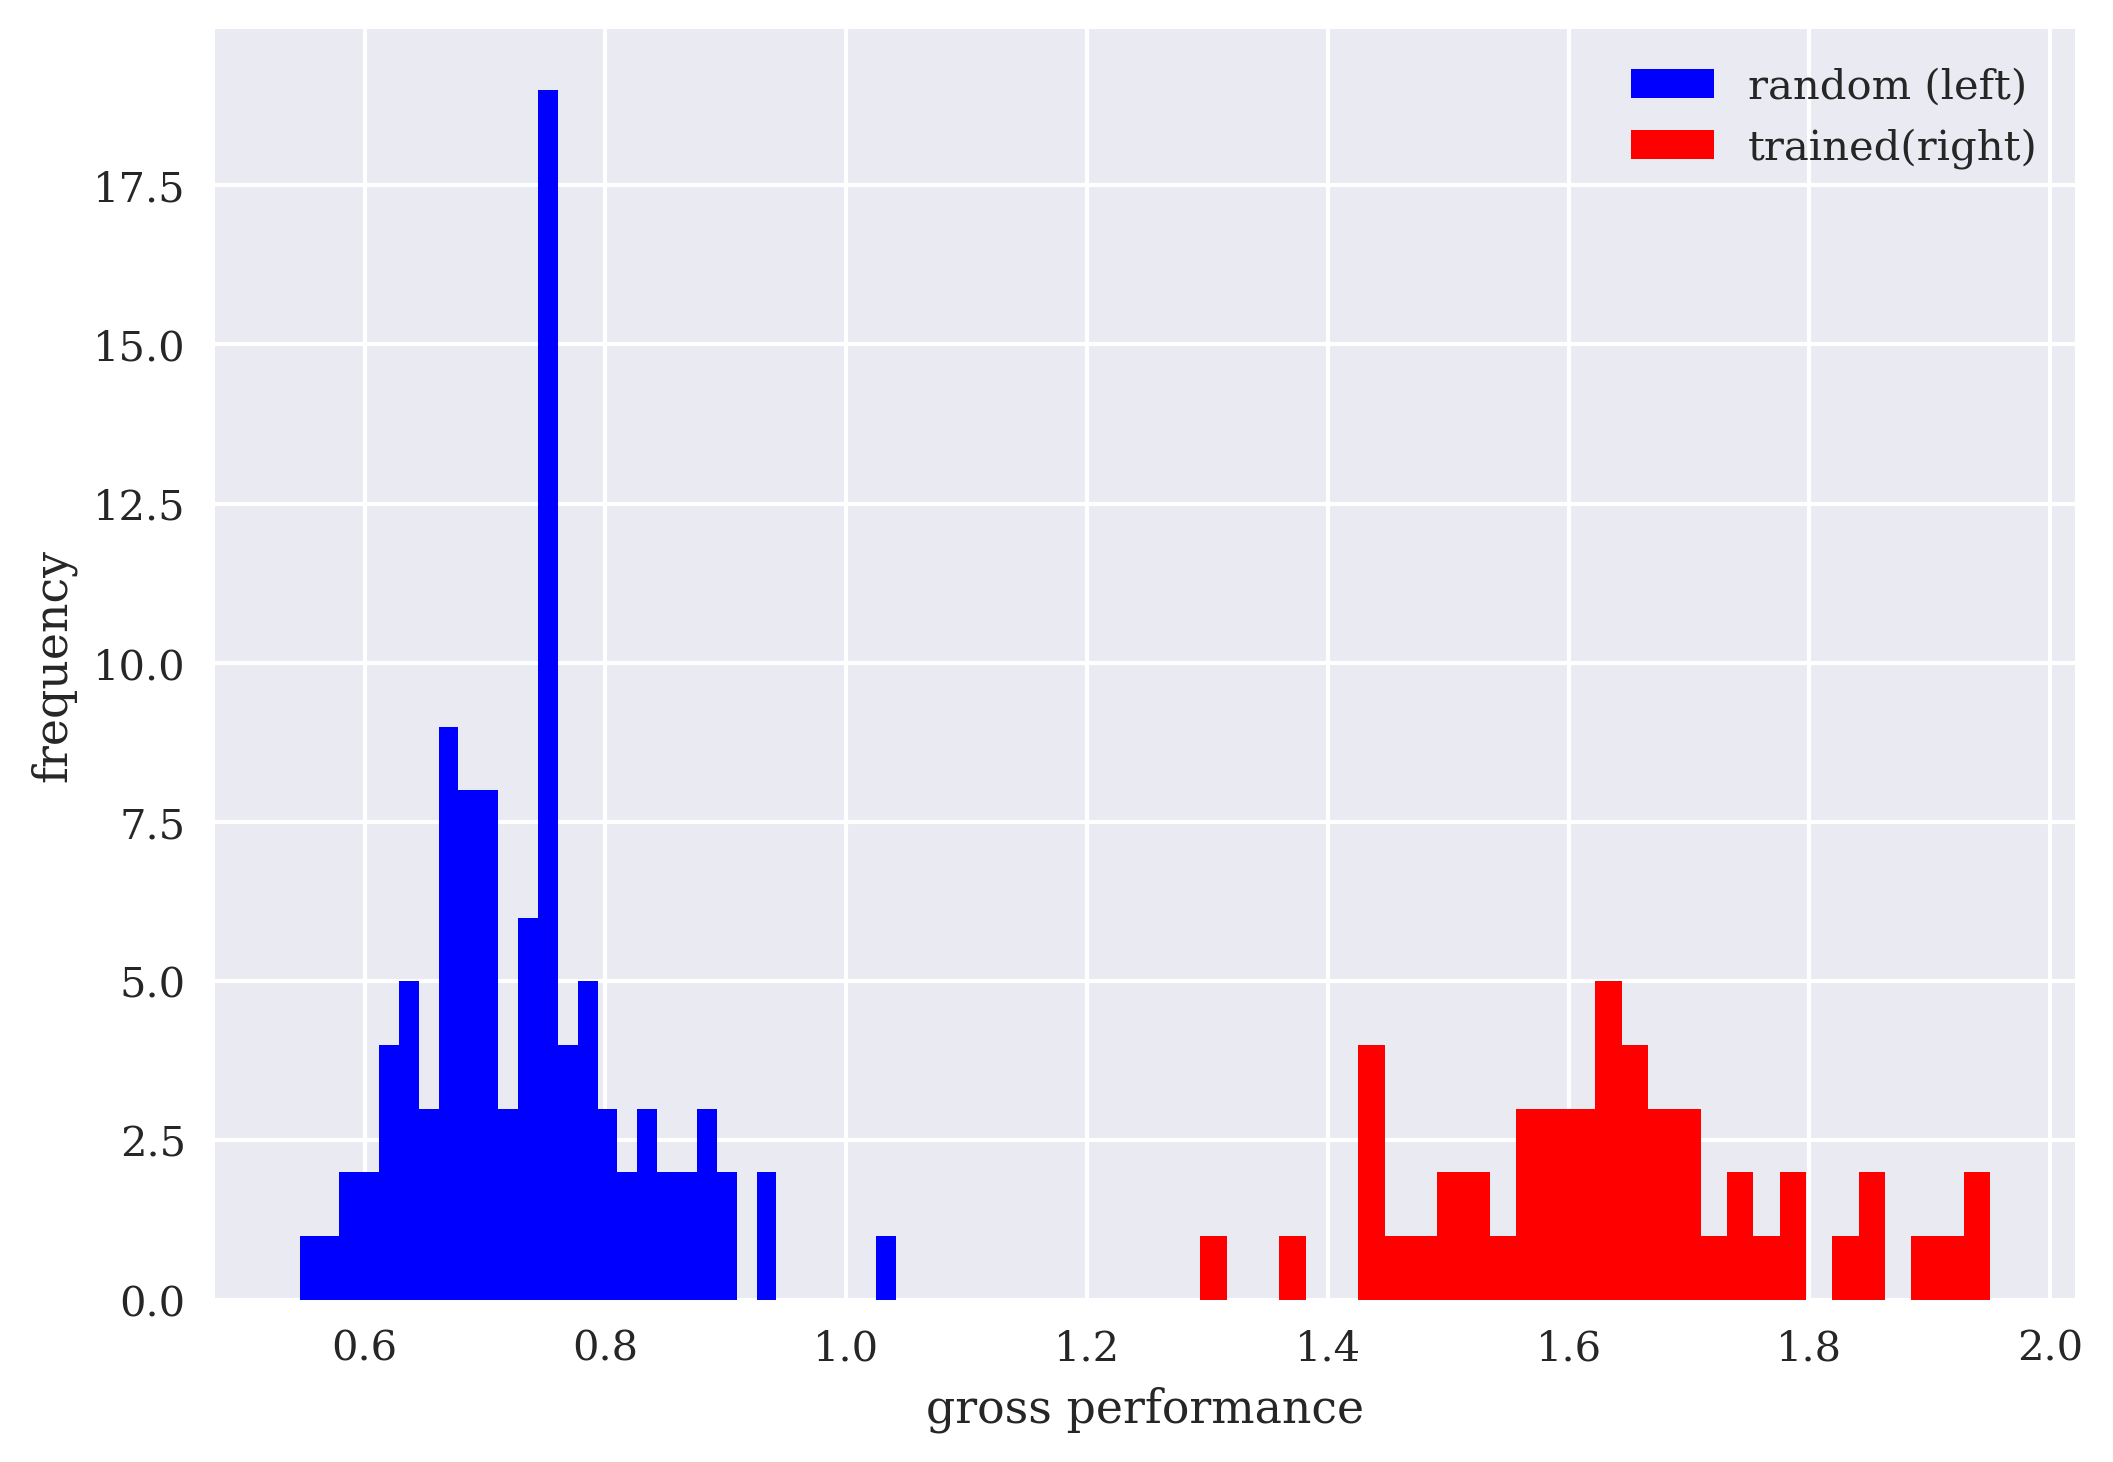

In [42]:
plt.hist(random_performances, bins=30,
         color='b', label='random (left)')
plt.hist(tradingagent.performances, bins=30,
         color='r', label='trained(right)')
plt.xlabel('gross performance')
plt.ylabel('frequency')
plt.legend();

<img src="https://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>

<a href="https://tpq.io" target="_blank">https://tpq.io</a> | <a href="https://twitter.com/dyjh" target="_blank">@dyjh</a> | <a href="mailto:team@tpq.io">team@tpq.io</a>